# Project Title
### Data Engineering Capstone Project

#### Project Summary

The objective of this capstone project is to build ETL pipeline for I94 immigration, US City Demographics, US Airports, and US port code datasets to create database tables for analytical purposes. With those data tables, Data Analysts can provide insights to the regulators to keep track of immigrants and their immigration informations. For examples, we could find answers to the questions such as, Which is the main characteristics of the city that are popular to the particular immigrants?


The project follows the follow steps:
* Step 0: Necessary codes import
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

### Step 0: Codes import that necessary


In [1]:
# !pip install pyspark --upgrade

In [1]:
# Do all imports and installs here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark
import psycopg2

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"

import configparser

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *

from utilities import missing_value_ratio, drop_duplicates_and_remeasure 
from sql_queries import usc_demograhics, immigrations, airports, portinfo



#### Load AWS config data

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID'] = config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['AWS']['AWS_SECRET_ACCESS_KEY']

#### Create Spark Sessions

In [3]:
	
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
.getOrCreate()

# config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
# Unable to access to saurfang's spark-sas7bdat - error : "Java gateway process exited before sending its port number"



In [4]:
# df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

# #write to parquet
# df_spark.write.parquet("sas_data")
# df_spark=spark.read.parquet("sas_data")

### Step 1: Scope the Project and Gather Data

#### Scope 

To create the analytics database, the following steps will be carried out:

1. Perform EDA of each datasets to find missing values, duplicates and any data quality problems.
2. Create dimesion and fact tables using SparkQL and AWS EMR clusters and then write tables into parquet file to the AWS S3 bucket.
  - create Immigration fact table from the I94 immigration dataset
     * In this project, I used 'sample csv file' due to an issue from access to 'saurfang:spark-sas7bdat' file through this local workspace
  - create Us City Demographics dimension table from the us-cities-demographics dataset. This table can be joined with other tables through the state code field.
  - create Us Airport codes dimension table from the airport-code dataset. This table can be joined with other tables through the iata code field.
  - create Port Info dimension table from I94_SAS_Labels_Descriptions text file. This table contains state code and iata code to each city name. 
 
3. To build this ETL pipeline, AWS S3 / AWS EMR cluster and Spark were used in this project. 

4. To run this ETL pipeline, user just run this ipynb file step by step.


In [5]:
# EDA Immigration data from sample csv file
# In this project, I used 'sample csv file' due to an issue from accessin 'saurfang:spark-sas7bdat' file through this local workspace

df_immg = pd.read_csv("immigration_data_sample.csv")
pd.options.display.max_columns = None
df_immg.name = 'Immigration data'
df_immg.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


#### Data Dictionary of the 'US immigration'

|Feature|Description|
|:-----|-----|
|cicid|Unique record ID|
|i94yr|4 digit year|
|i94mon|Numeric month|
|i94cit|3 digit code for immigrant country of birth|
|i94res|3 digit code for immigrant country of residence|
|i94port|Port of admission|
|arrdate|Arrival Date in the USA|
|i94mode|Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)|
|i94addr|USA State of arrival|
|depdate|Departure Date from the USA|
|i94bir|Age of Respondent in Years|
|i94visa|Visa codes collapsed into three categories|
|count|Field used for summary statistics|
|dtadfile|Character Date Field - Date added to I-94 Files|
|visapost|Department of State where where Visa was issued|
|occup|Occupation that will be performed in U.S|
|entdepa|Arrival Flag - admitted or paroled into the U.S.|
|entdepd|Departure Flag - Departed, lost I-94 or is deceased|
|entdepu|Update Flag - Either apprehended, overstayed, adjusted to perm residence|
|matflag|Match flag - Match of arrival and departure records|
|biryear|4 digit year of birth|
|dtaddto|Character Date Field - Date to which admitted to U.S. (allowed to stay until)|
|gender|Non-immigrant sex|
|insnum|INS number|
|airline|Airline used to arrive in U.S.|
|admnum|Admission Number|
|fltno|Flight number of Airline used to arrive in U.S.|
|visatype|Class of admission legally admitting the non-immigrant to temporarily stay in U.S.|

In [6]:
#airport-codes data
df_airport = pd.read_csv("airport-codes_csv.csv")
df_airport.name = 'Airport data'
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Airport data,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Airport data,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Airport data,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Airport data,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Airport data,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [7]:
df_airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
ident           55075 non-null object
type            55075 non-null object
name            55075 non-null object
elevation_ft    48069 non-null float64
continent       27356 non-null object
iso_country     54828 non-null object
iso_region      55075 non-null object
municipality    49399 non-null object
gps_code        41030 non-null object
iata_code       9189 non-null object
local_code      28686 non-null object
coordinates     55075 non-null object
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


#### Data Dictionary of the 'Airports'
link : https://ourairports.com/help/data-dictionary.html

|Feature|Description|
|:------|------|
|id|Internal OurAirports integer identifier for the airport. This will stay persistent, even if the airport code changes.|
|ident|The text identifier used in the OurAirports URL. This will be the ICAO code if available. Otherwise, it will be a local airport code (if no conflict), or if nothing else is available, an internally-generated code starting with the ISO2 country code, followed by a dash and a four-digit number.|
|type|The type of the airport. Allowed values are "closed_airport", "heliport", "large_airport", "medium_airport", "seaplane_base", and "small_airport". See the map legend for a definition of each type.|
|name|The official airport name, including "Airport", "Airstrip", etc.|
|elevation_ft|The airport elevation MSL in feet (not metres).|
|continent|The code for the continent where the airport is (primarily) located. Allowed values are "AF" (Africa), "AN" (Antarctica), "AS" (Asia), "EU" (Europe), "NA" (North America), "OC" (Oceania), or "SA" (South America).|
|iso_country|The two-character ISO 3166:1-alpha2 code for the country where the airport is (primarily) located. A handful of unofficial, non-ISO codes are also in use, such as "XK" for Kosovo. Points to the code column in countries.csv.|
|iso_region|An alphanumeric code for the high-level administrative subdivision of a country where the airport is primarily located (e.g. province, governorate), prefixed by the ISO2 country code and a hyphen. OurAirports uses ISO 3166:2 codes whenever possible, preferring higher administrative levels, but also includes some custom codes. See the documentation for regions.csv.|
|municipality|The primary municipality that the airport serves (when available). Note that this is not necessarily the municipality where the airport is physically located.|
scheduled_service|"yes" if the airport currently has scheduled airline service; "no" otherwise.|
|gps_code|The code that an aviation GPS database (such as Jeppesen's or Garmin's) would normally use for the airport. This will always be the ICAO code if one exists. Note that, unlike the ident column, this is not guaranteed to be globally unique.|
|iata_code|The three-letter IATA code for the airport (if it has one).|
|local_code|The local country code for the airport, if different from the gps_code and iata_code fields (used mainly for US airports).|
|coordinates|The airport latitude in decimal degrees (positive for north)., The airport longitude in decimal degrees (positive for east).|

In [8]:
#us-cities-demographics data
df_uscdemo = pd.read_csv("us-cities-demographics.csv", delimiter=";")
df_uscdemo.name = 'U.S. City Demographics data'
df_uscdemo.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Data Dictionary of the 'US City Demographics'

|Feature|Description|
|:------|------|
|City|City Name|
|State|US State where city is located|
|Median Age|Median age of the population|
|Male Population|Count of male population|
|Female Population|Count of female population|
|Total Population|Count of total population|
|Number of Veterans|Count of total Veterans|
|Foreign born|Count of residents of the city that were not born in the city|
|Average Household Size|Average city household size|
|State Code|Code of the US state|
|Race|Respondent race|
|Count|Count of city's individual per race|

In [9]:
# U.S. Ports Info from SAS text file
# Get ports info to mapping port codes with city and state code from SAS file.
with open("./I94_SAS_Labels_Descriptions.SAS") as i94_labels:
    content = i94_labels.readlines()
content = [x.strip() for x in content]
ports = content[302:962]
port_codes = [x[0].replace("'","").strip() for x in [port.split("=") for port in ports]]
i94prtl = [x[1].replace("'","").strip() for x in [port.split("=") for port in ports]]
port_cities = [x.split(",")[0] for x in i94prtl]
port_states = [x.split(",")[-1] for x in i94prtl]
df_portinfo = pd.DataFrame({"port_code" : port_codes, "city": port_cities, "state_code": port_states})

df_portinfo.name = 'U.S. Port Information data'

df_portinfo.head()

,port_code,city,state_code
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


#### Data Dictionary of the 'Port Info'

|Feature|Description|
|:------|------|
|port_code|The three-letter IATA code for the airport|
|city|city name with upper cases|
|state_code|state code|


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.
And elaborate some columns to build model that can be foreign key
 - 1) Check missing values and drop if necessary
 - 2) Check duplicated rows and drop if necessary
 - 3) Clean columns and values if necessary
     - Change value type
     - Change upper cases to low cases or vice versa
 - 5) Elaborate Columns that could be used as foreign key
 

### 1) visualize missing value ratio with bar plot

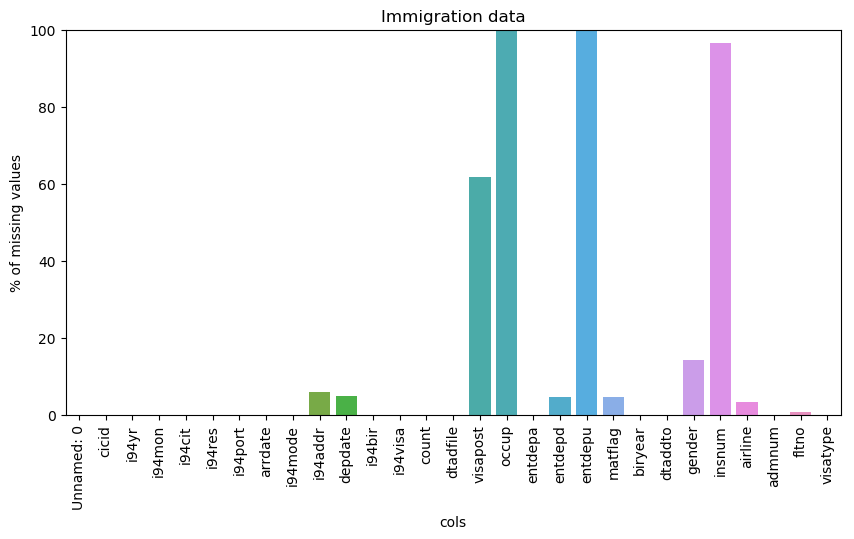

U.S. Immigration data Summary : The missing value proportion of the 'visapost', 'occup', 'entdepu', 'insnum' column are high. 
 If those are necesarry to analysis, We need data to fill the missing values. Otherwise, Need to decide delete them or not


In [10]:
missing_value_ratio(df_immg)

print("U.S. Immigration data Summary : The missing value proportion of the 'visapost', 'occup', 'entdepu', 'insnum' column are high. \n If those are necesarry to analysis, We need data to fill the missing values. Otherwise, Need to decide delete them or not")

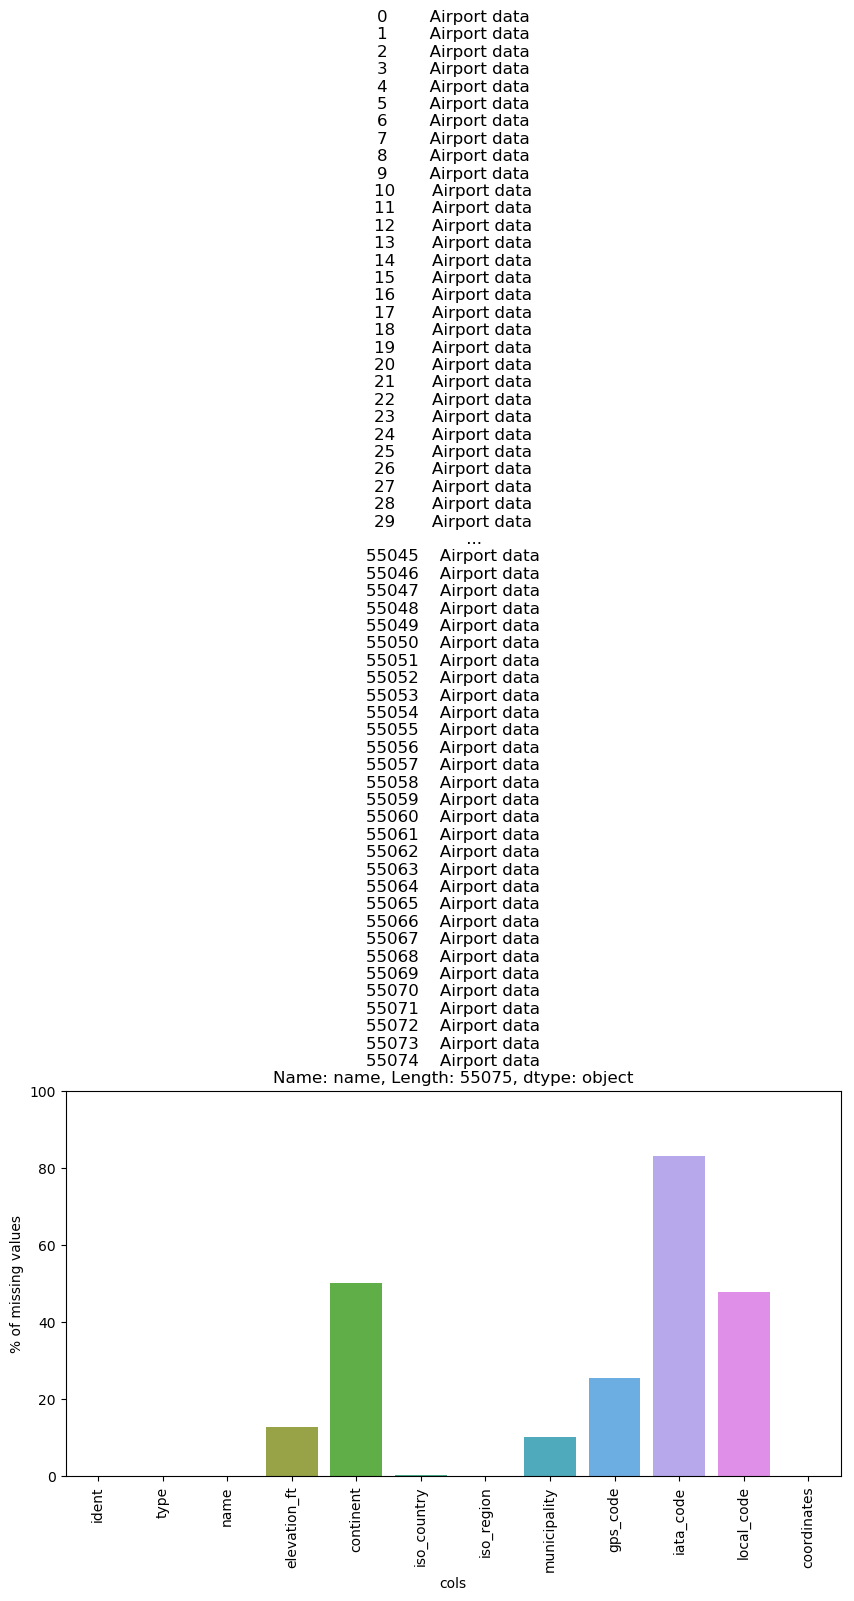

U.S. Airport data Summary : The missing value proportion of the 'iata_code', 'local_code', 'continent' column are high. 
 If those are necesarry to analysis, We need data to fill the missing values. Otherwise, Need to decide delete them or not


In [11]:
missing_value_ratio(df_airport)

print("U.S. Airport data Summary : The missing value proportion of the 'iata_code', 'local_code', 'continent' column are high. \n If those are necesarry to analysis, We need data to fill the missing values. Otherwise, Need to decide delete them or not")


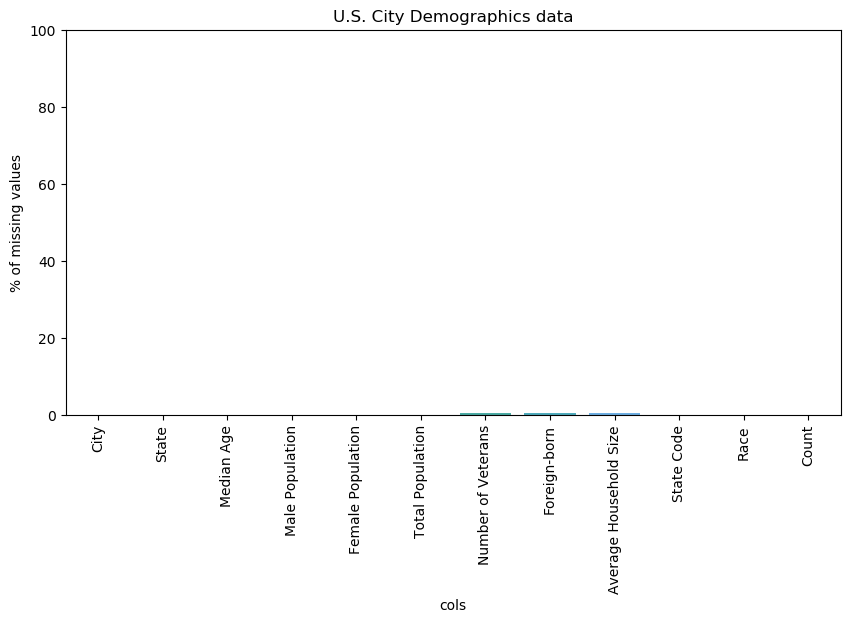

U.S. City Demographic data Summary : There are some missing values in 'Number of Veterans', 'Foreign-born', 'Average Household size' 
 So the data has few missing values, it is ok to drop rows with missing values


In [12]:
missing_value_ratio(df_uscdemo)

print("U.S. City Demographic data Summary : There are some missing values in 'Number of Veterans', 'Foreign-born', 'Average Household size' \n So the data has few missing values, it is ok to drop rows with missing values")


### 1-1) Drop rows and columns that have over 90% missing values

In [13]:
# Drop columns that have over 90% missing values in US Immigration data
drop_cols = ['Unnamed: 0', 'occup', 'entdepu', 'insnum']
df_immg = df_immg.drop(columns = drop_cols)

df_immg.columns

Index(['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate',
       'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count',
       'dtadfile', 'visapost', 'entdepa', 'entdepd', 'matflag', 'biryear',
       'dtaddto', 'gender', 'airline', 'admnum', 'fltno', 'visatype'],
      dtype='object')

In [14]:
df_immg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
cicid       1000 non-null float64
i94yr       1000 non-null float64
i94mon      1000 non-null float64
i94cit      1000 non-null float64
i94res      1000 non-null float64
i94port     1000 non-null object
arrdate     1000 non-null float64
i94mode     1000 non-null float64
i94addr     941 non-null object
depdate     951 non-null float64
i94bir      1000 non-null float64
i94visa     1000 non-null float64
count       1000 non-null float64
dtadfile    1000 non-null int64
visapost    382 non-null object
entdepa     1000 non-null object
entdepd     954 non-null object
matflag     954 non-null object
biryear     1000 non-null float64
dtaddto     1000 non-null object
gender      859 non-null object
airline     967 non-null object
admnum      1000 non-null float64
fltno       992 non-null object
visatype    1000 non-null object
dtypes: float64(13), int64(1), object(11)
memory usage: 195.4+ KB

In [15]:
# Drop rows that have missing value in US City Demo data
print("rows before drop missing value columns : \n", df_uscdemo.count())

missing_value_cols = ['Number of Veterans', 'Foreign-born', 'Average Household Size']
before_rows = df_uscdemo.count()
df_uscdemo = df_uscdemo.dropna(subset=missing_value_cols)
dropped_rows = before_rows - df_uscdemo.count()

print("\n rows after drop missing value columns : \n", df_uscdemo.count())
print("\n rows dropped that have missing value : \n", dropped_rows)


rows before drop missing value columns : 
 City                      2891
State                     2891
Median Age                2891
Male Population           2888
Female Population         2888
Total Population          2891
Number of Veterans        2878
Foreign-born              2878
Average Household Size    2875
State Code                2891
Race                      2891
Count                     2891
dtype: int64

 rows after drop missing value columns : 
 City                      2875
State                     2875
Median Age                2875
Male Population           2875
Female Population         2875
Total Population          2875
Number of Veterans        2875
Foreign-born              2875
Average Household Size    2875
State Code                2875
Race                      2875
Count                     2875
dtype: int64

 rows dropped that have missing value : 
 City                      16
State                     16
Median Age                16
Male Populati

### 2) Check duplicated rows and drop them

In [16]:
# Check duplicated rows

print("Duplicate checks - U.S. Immigration data")
drop_duplicates_and_remeasure(df_immg)

Duplicate checks - U.S. Immigration data
duplicated rows count :  0
duplicated rows count after drops :  0


In [17]:
print("Duplicate checks - U.S. Airport data")
drop_duplicates_and_remeasure(df_airport)

Duplicate checks - U.S. Airport data
duplicated rows count :  0
duplicated rows count after drops :  0


In [18]:

print("Duplicate checks - U.S. City Demo data")
drop_duplicates_and_remeasure(df_uscdemo)

Duplicate checks - U.S. City Demo data
duplicated rows count :  0
duplicated rows count after drops :  0


### 3) Clean columns and values if necessary


### 3-1) Change Data types which can trigger Type error when merging pandas DataFrame to Spark DataFrame
 Usually columns that has Object types which able to misinterpreted as double or float types

In [19]:
cols = df_airport.columns
for i in cols :
    if df_airport[i].dtypes == 'O' :
        df_airport[i] = df_airport[i].astype('str')

df_airport['gps_code'].dtypes    

dtype('O')

In [20]:
# Immigration file
def types_change(df, type) :
    cols = df.columns
    for i in cols :
        if df[i].dtypes == 'O' :
            df[i] = df[i].astype(type)

types_change(df_immg, 'str')
types_change(df_uscdemo, 'str')
types_change(df_airport, 'str')
types_change(df_portinfo, 'str')

### 3-2) Change name of columns with lower cases and replace blanks

In [21]:
# df_uscdemo
df_uscdemo.columns = df_uscdemo.columns.str.replace(" ", "_")
df_uscdemo.columns = df_uscdemo.columns.str.replace("-", "_")
df_uscdemo.columns = df_uscdemo.columns.str.lower()

df_uscdemo.head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


### 4) Elaborate Columns that could be used as foreign key
  - Airport Data : iso_region columns to used as state_code by replacing 'US-' prefix into blank


In [22]:
df_airport.iso_region = df_airport.iso_region.str.replace('US-', '')

df_airport.iso_region.head()

0    PA
1    KS
2    AK
3    AL
4    AR
Name: iso_region, dtype: object

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model


|U.S. City Demo|U.S. Airport|U.S. Immigration|U.S. Port Info|
|--------------|--------------|--------------|--------------|
|<img src="table_model_uscdemo.png" height="450px" width="300px">|<img src="table_model_airport.png" height="450px" width="300px">|<img src="table_model_immgration.png" height="450px" width="300px">|<img src="table_model_portinfo.png" height="450px" width="300px">|



#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

1. Create tables through running create_tables.py
        1) create us city demographic dimension table
        2) create us airpot dimension table
        3) create us immigration fact table
        4) create us port infomation dismension table
2. Insert 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [42]:
# Creating Spark Session is already done before.

# Processing read and extract, load Immigration(Sample) file 

def process_immg_table(spark, input_data, output_data):
    """
    Load data from immg file which stored in this local workspace
    and extract columns and create tables using written sql query from sql_query.py
    and writing immigration table into parquet
    and the files will be loaded on S3 bucket
    
    Parameters
    ----------
    spark: session
          spark session that has been created
    input_data: dataframe file
          name of the immg dataFrame file from local workspace
    output_data: path
          path to where the parquet files will be written.
    """
    
    # read immg data file
    df = spark.createDataFrame(input_data)
    print('loading of immg_data files complete: ' + str(datetime.now()))
    
    # extract columns to create immg table
    df.createOrReplaceTempView('immg')
    immg_table = spark.sql(immigrations)

    # write immg table to parquet files partitioned by i94year and i94 month
    print('writing immg table to S3: ' + str(datetime.now()))
    immg_table.write.partitionBy('i94yr', 'i94mon')\
                    .parquet(os.path.join(output_data, 'immg/immg.parquet'), 'overwrite')
    print('write of immg table to S3 complete: ' + str(datetime.now()))

    return immg_table

    
# Processing read and extract, load US demographic file 

def process_demo_table(spark, input_data, output_data):
    """
    Load data from us city demo file which stored in this local workspace
    and extract columns and create table using uscdemo with using sql_query.py
    and writing uscdemo table into parquet
    and the files will be loaded on S3 bucket
    
    Parameters
    ----------
    spark: session
          spark session that has been created
    input_data: dataframe file
          name of the uscdemo dataFrame file from local workspace
    output_data: path
          path to where the parquet files will be written.
    """
    df = spark.createDataFrame(input_data)
    print('loading of uscdemo data from S3 complete: ' + str(datetime.now()))
    
    # extract columns for users table   
    df.createOrReplaceTempView("uscdemo")
    uscdemo_table = spark.sql(usc_demograhics)

    # write users table to parquet files
    print('writing uscdemo table to S3: ' + str(datetime.now()))
    uscdemo_table.write.partitionBy('state')\
            .parquet(os.path.join(output_data, 'uscdemo/uscdemo.parquet'), 'overwrite')
    print('loading of uscdemo table to S3: ' + str(datetime.now()))

    return uscdemo_table


# Processing read and extract, load US airport file 
    
def process_airport_table(spark, input_data, output_data):
    """
    Load data from airport file which stored in this local workspace
    and extract columns and create tables using airports with using sql_query.py
    and writing airport table into parquet
    and the files will be loaded on S3 bucket
    
    Parameters
    ----------
    spark: session
          spark session that has been created
    input_data: dataframe file
          name of the airports dataFrame file from local workspace
    output_data: path
          path to where the parquet files will be written.
    """
    df = spark.createDataFrame(input_data)
    print('loading of airport data from S3 complete: ' + str(datetime.now()))
    
    # extract columns for airport table   
    df.createOrReplaceTempView("airports")
    airports_table = spark.sql(airports)

    # write airports table to parquet files
    print('writing airports table to S3: ' + str(datetime.now()))
    airports_table.write.partitionBy('iata_code')\
                .parquet(os.path.join(output_data, 'airports/airports.parquet'), 'overwrite')
    print('loading of airports table to S3: ' + str(datetime.now()))

    return airports_table


# Processing read and extract, load portinfo file 
    
def process_portinfo_table(spark, input_data, output_data):
    """
    Load data from portinfo file which stored in this local workspace
    and extract columns and create table using portinfo with using sql_query.py
    and writing portinfo table into parquet
    and the files will be loaded on S3 bucket
    
    Parameters
    ----------
    spark: session
          spark session that has been created
    input_data: dataframe file
          name of the airports dataFrame file from local workspace
    output_data: path
          path to where the parquet files will be written.
    """
    df = spark.createDataFrame(input_data)
    print('loading of portinfo data from S3 complete: ' + str(datetime.now()))
    
    # extract columns for portinfo table   
    df.createOrReplaceTempView("portinfo")
    portinfo_table = spark.sql(portinfo)

    # write portinfo table to parquet files
    print('writing portinfo table to S3: ' + str(datetime.now()))
    portinfo_table.write\
                .parquet(os.path.join(output_data, 'portinfo/portinfo.parquet'), 'overwrite')
    print('loading of portinfo table to S3: ' + str(datetime.now()))
    
    return portinfo_table

In [39]:
# Run ETL  
"""
Perform the following roles:
1.) Get or create a spark session(Already done before EDA process)
1.) Read the 4 dataFrame file from workspace.
2.) Extract and Transform them into tables
3.) Write and Load the parquet files on s3.
"""

output_data = "s3a://tse-udacity-nano-de/capstone/"

## After 1st submition(2021.06.27) : Allocate each spark df table into variable and Seperated def functions with run codes
immg_table = process_immg_table(spark, df_immg, output_data)    
uscdemo_table = process_demo_table(spark, df_uscdemo, output_data)    
airports_table = process_airport_table(spark, df_airport, output_data)    
portinfo_table = process_portinfo_table(spark, df_portinfo, output_data)    


#### 4.2 Data Quality Checks
The data quality checks ensures that the ETL has created fact and dimension tables with expected records without errors.
 

In [45]:
# quality check

def data_quality_check(df, table_name):
    """row count checks on each table
    :param df: spark table to check that returned after processing tables
    :param table_name: table name that stored in S3 bucket
    """
    record_count = df.count()

    if record_count == 0:
        print(f"Data quality check failed : {table_name} has 0 records")
    else:
        print(f"Data quality check passed : {table_name} has {record_count:,} records")
    return print("data quality check process - Complete!")

data_quality_check(immg_table, "immg_table")
data_quality_check(uscdemo_table, "uscdemo_table")
data_quality_check(airports_table, "airports_table")
data_quality_check(portinfo_table, "portinfo_table")



Data quality check passed : portinfo_table has 660 records
data quality check process - Complete!


#### 4.3 Data dictionary 
Included in the "Step 1: Scope the Project and Gather Data"


#### Step 5: Complete Project Write Up

1. Rationale for the choice of tools and technologies for the project
 - 1) Apache Spark
      - Able to handle multiple file formats and lightning-fast unified analytics engine for Big Data.
      - Spark has easy-to-use APIs for operating on large datasets
  
  
2. Propose how often the data should be updated and why.
  - Our Fact table, I94 Immigration data is updated by monthly, so we have to monthly append procedure into our database


3. Write a description of how you would approach the problem differently under the following scenarios:
 - 1) The data was increased by 100x.
    - Still Apache Spark can handle multiplied data scale. But We have to consider add more nodes to our EMR clusters.
 - 2) The data populates a dashboard that must be updated on a daily basis by 7am every day.
    - To monitor and manage each ETL process and trouble shooting, Apache Airflow would be solution.
 - 3) The database needed to be accessed by 100+ people.
    - In this scenario, we would move our analytics database into Amazon Redshift.